<a href="https://colab.research.google.com/github/ab3131/NBAInjuryPredictor/blob/main/NBAInjuryPredictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Statements

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Data Cleaning

In [2]:
player_stats = pd.read_csv('player_stats.csv')
injuries_original = pd.read_csv('NBA Player Injury Stats(1951 - 2023).csv')

In [3]:
player_stats.columns[0]


'Unnamed: 0'

In [4]:
injuries_original.columns[0]

'Unnamed: 0'

In [5]:
player_stats = player_stats.drop(columns = player_stats.columns[0], axis=1)

In [6]:
player_stats

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,Randy Livingston,HOU,22.0,193.04,94.800728,Louisiana State,USA,1996,2,42,...,3.9,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996-97
1,Gaylon Nickerson,WAS,28.0,190.50,86.182480,Northwestern Oklahoma,USA,1994,2,34,...,3.8,1.3,0.3,8.9,0.030,0.111,0.174,0.497,0.043,1996-97
2,George Lynch,VAN,26.0,203.20,103.418976,North Carolina,USA,1993,1,12,...,8.3,6.4,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,1996-97
3,George McCloud,LAL,30.0,203.20,102.058200,Florida State,USA,1989,1,7,...,10.2,2.8,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,1996-97
4,George Zidek,DEN,23.0,213.36,119.748288,UCLA,USA,1995,1,22,...,2.8,1.7,0.3,-14.1,0.102,0.169,0.195,0.500,0.064,1996-97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12839,Joel Embiid,PHI,29.0,213.36,127.005760,Kansas,Cameroon,2014,1,3,...,33.1,10.2,4.2,8.8,0.057,0.243,0.370,0.655,0.233,2022-23
12840,John Butler Jr.,POR,20.0,213.36,86.182480,Florida State,USA,Undrafted,Undrafted,Undrafted,...,2.4,0.9,0.6,-16.1,0.012,0.065,0.102,0.411,0.066,2022-23
12841,John Collins,ATL,25.0,205.74,102.511792,Wake Forest,USA,2017,1,19,...,13.1,6.5,1.2,-0.2,0.035,0.180,0.168,0.593,0.052,2022-23
12842,Jericho Sims,NYK,24.0,208.28,113.398000,Texas,USA,2021,2,58,...,3.4,4.7,0.5,-6.7,0.117,0.175,0.074,0.780,0.044,2022-23


In [7]:
injuries_original = injuries_original.drop(columns=injuries_original.columns[0], axis=1)

In [8]:
injuries_original

,Date,Team,Acquired,Relinquished,Notes
0,1951-12-25,Bullets,NaN,Don Barksdale,placed on IL
1,1952-12-26,Knicks,NaN,Max Zaslofsky,placed on IL with torn side muscle
2,1956-12-29,Knicks,NaN,Jim Baechtold,placed on inactive list
3,1959-01-16,Lakers,NaN,Elgin Baylor,player refused to play after being denied a ro...
4,1961-11-26,Lakers,NaN,Elgin Baylor,player reported for military duty
...,...,...,...,...,...
37662,2023-04-16,Clippers,Marcus Morris,NaN,activated from IL
37663,2023-04-16,Grizzlies,Dillon Brooks,NaN,activated from IL
37664,2023-04-16,Grizzlies,Ja Morant,NaN,activated from IL
37665,2023-04-16,Grizzlies,Jaren Jackson Jr.,NaN,activated from IL


Filter out injuries prior to 1996, where the player_stats dataset begins. We also don't want any rows where someone was activated, we care about the injury itself

In [9]:
injuries_date_filtered = injuries_original[(injuries_original['Date']>'1996-07-01') & (injuries_original['Date']<'2023-07-01')]

In [10]:
injuries_date_filtered

,Date,Team,Acquired,Relinquished,Notes
2055,1996-09-11,Pacers,NaN,Rik Smits,placed on IR with surgery on feet (date approx...
2056,1996-10-30,Blazers,NaN,Aleksandar Djordjevic,placed on IL with sprained right ankle
2057,1996-10-30,Blazers,NaN,Jermaine O'Neal,placed on IL with sprained left knee / bone co...
2058,1996-10-30,Blazers,NaN,Marcus Brown,placed on IL with strained right groin
2059,1996-10-30,Knicks,NaN,Chris Childs,placed on IR with broken right leg
...,...,...,...,...,...
37662,2023-04-16,Clippers,Marcus Morris,NaN,activated from IL
37663,2023-04-16,Grizzlies,Dillon Brooks,NaN,activated from IL
37664,2023-04-16,Grizzlies,Ja Morant,NaN,activated from IL
37665,2023-04-16,Grizzlies,Jaren Jackson Jr.,NaN,activated from IL


Removing Relinquished Column

In [11]:
injuries = injuries_date_filtered[~(injuries_date_filtered['Relinquished'].isna())]

In [12]:
injuries

,Date,Team,Acquired,Relinquished,Notes
2055,1996-09-11,Pacers,NaN,Rik Smits,placed on IR with surgery on feet (date approx...
2056,1996-10-30,Blazers,NaN,Aleksandar Djordjevic,placed on IL with sprained right ankle
2057,1996-10-30,Blazers,NaN,Jermaine O'Neal,placed on IL with sprained left knee / bone co...
2058,1996-10-30,Blazers,NaN,Marcus Brown,placed on IL with strained right groin
2059,1996-10-30,Knicks,NaN,Chris Childs,placed on IR with broken right leg
...,...,...,...,...,...
37624,2023-04-09,Grizzlies,NaN,Ja Morant,placed on IL with right hand injury
37625,2023-04-09,Grizzlies,NaN,Jaren Jackson Jr.,placed on IL with sore left elbow
37630,2023-04-09,Kings,NaN,Davion Mitchell,placed on IL with sore left knee
37631,2023-04-09,Knicks,NaN,Trevor Keels,placed on IL with illness


In [13]:
injuries = injuries.drop(columns = 'Acquired')

When combining, have to keep date(convert to season?), team, relinquished, and notes

In [14]:
injuries = injuries.reset_index(drop=True)

In [15]:
injuries

,Date,Team,Relinquished,Notes
0,1996-09-11,Pacers,Rik Smits,placed on IR with surgery on feet (date approx...
1,1996-10-30,Blazers,Aleksandar Djordjevic,placed on IL with sprained right ankle
2,1996-10-30,Blazers,Jermaine O'Neal,placed on IL with sprained left knee / bone co...
3,1996-10-30,Blazers,Marcus Brown,placed on IL with strained right groin
4,1996-10-30,Knicks,Chris Childs,placed on IR with broken right leg
...,...,...,...,...
18887,2023-04-09,Grizzlies,Ja Morant,placed on IL with right hand injury
18888,2023-04-09,Grizzlies,Jaren Jackson Jr.,placed on IL with sore left elbow
18889,2023-04-09,Kings,Davion Mitchell,placed on IL with sore left knee
18890,2023-04-09,Knicks,Trevor Keels,placed on IL with illness


Separate stats by season for categorization(Season starts on October 12th, ends October 11th of next year)

In [16]:
def find_season(date):
  year = int(date[0:4])
  month = int(date[5:7])
  day = int(date[8:10])
  if month<10:
    return year-1
  elif month==10:
    if day<12:
      return year-1
    else:
      return year
  else:
    return year

In [17]:
injuries['Date'] = injuries['Date'].apply(find_season)

In [18]:
injuries

,Date,Team,Relinquished,Notes
0,1995,Pacers,Rik Smits,placed on IR with surgery on feet (date approx...
1,1996,Blazers,Aleksandar Djordjevic,placed on IL with sprained right ankle
2,1996,Blazers,Jermaine O'Neal,placed on IL with sprained left knee / bone co...
3,1996,Blazers,Marcus Brown,placed on IL with strained right groin
4,1996,Knicks,Chris Childs,placed on IR with broken right leg
...,...,...,...,...
18887,2022,Grizzlies,Ja Morant,placed on IL with right hand injury
18888,2022,Grizzlies,Jaren Jackson Jr.,placed on IL with sore left elbow
18889,2022,Kings,Davion Mitchell,placed on IL with sore left knee
18890,2022,Knicks,Trevor Keels,placed on IL with illness


In [19]:
def one_year(season):
  return int(season[0:4])

In [20]:
player_stats['season'] = player_stats['season'].apply(one_year)

In [21]:
player_stats

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,Randy Livingston,HOU,22.0,193.04,94.800728,Louisiana State,USA,1996,2,42,...,3.9,1.5,2.4,0.3,0.042,0.071,0.169,0.487,0.248,1996
1,Gaylon Nickerson,WAS,28.0,190.50,86.182480,Northwestern Oklahoma,USA,1994,2,34,...,3.8,1.3,0.3,8.9,0.030,0.111,0.174,0.497,0.043,1996
2,George Lynch,VAN,26.0,203.20,103.418976,North Carolina,USA,1993,1,12,...,8.3,6.4,1.9,-8.2,0.106,0.185,0.175,0.512,0.125,1996
3,George McCloud,LAL,30.0,203.20,102.058200,Florida State,USA,1989,1,7,...,10.2,2.8,1.7,-2.7,0.027,0.111,0.206,0.527,0.125,1996
4,George Zidek,DEN,23.0,213.36,119.748288,UCLA,USA,1995,1,22,...,2.8,1.7,0.3,-14.1,0.102,0.169,0.195,0.500,0.064,1996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12839,Joel Embiid,PHI,29.0,213.36,127.005760,Kansas,Cameroon,2014,1,3,...,33.1,10.2,4.2,8.8,0.057,0.243,0.370,0.655,0.233,2022
12840,John Butler Jr.,POR,20.0,213.36,86.182480,Florida State,USA,Undrafted,Undrafted,Undrafted,...,2.4,0.9,0.6,-16.1,0.012,0.065,0.102,0.411,0.066,2022
12841,John Collins,ATL,25.0,205.74,102.511792,Wake Forest,USA,2017,1,19,...,13.1,6.5,1.2,-0.2,0.035,0.180,0.168,0.593,0.052,2022
12842,Jericho Sims,NYK,24.0,208.28,113.398000,Texas,USA,2021,2,58,...,3.4,4.7,0.5,-6.7,0.117,0.175,0.074,0.780,0.044,2022


In [22]:
injuries = injuries.rename(columns={"Relinquished": "player_name"})
injuries = injuries.rename(columns={"Date": "season"})

In [23]:
injuries

,season,Team,player_name,Notes
0,1995,Pacers,Rik Smits,placed on IR with surgery on feet (date approx...
1,1996,Blazers,Aleksandar Djordjevic,placed on IL with sprained right ankle
2,1996,Blazers,Jermaine O'Neal,placed on IL with sprained left knee / bone co...
3,1996,Blazers,Marcus Brown,placed on IL with strained right groin
4,1996,Knicks,Chris Childs,placed on IR with broken right leg
...,...,...,...,...
18887,2022,Grizzlies,Ja Morant,placed on IL with right hand injury
18888,2022,Grizzlies,Jaren Jackson Jr.,placed on IL with sore left elbow
18889,2022,Kings,Davion Mitchell,placed on IL with sore left knee
18890,2022,Knicks,Trevor Keels,placed on IL with illness


In [24]:
player_stats['season'] = player_stats['season'].astype(int)
injuries['season'] = injuries['season'].astype(int)
player_stats['player_name'] = player_stats['player_name'].astype(str)
injuries['player_name'] = injuries['player_name'].astype(str)


In [25]:
final = pd.merge( injuries, player_stats, how='outer', left_on=['season', 'player_name'], right_on = ['season', 'player_name'])

In [26]:
final

,season,Team,player_name,Notes,team_abbreviation,age,player_height,player_weight,college,country,...,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct
0,1995,Pacers,Rik Smits,placed on IR with surgery on feet (date approx...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1996,Blazers,Aleksandar Djordjevic,placed on IL with sprained right ankle,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1996,Blazers,Aleksandar Djordjevic,placed on IL with flu,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1996,Blazers,Jermaine O'Neal,placed on IL with sprained left knee / bone co...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1996,Blazers,Marcus Brown,placed on IL with strained right groin,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31731,2022,NaN,Joel Embiid,NaN,PHI,29.0,213.36,127.005760,Kansas,Cameroon,...,66.0,33.1,10.2,4.2,8.8,0.057,0.243,0.370,0.655,0.233
31732,2022,NaN,John Butler Jr.,NaN,POR,20.0,213.36,86.182480,Florida State,USA,...,19.0,2.4,0.9,0.6,-16.1,0.012,0.065,0.102,0.411,0.066
31733,2022,NaN,John Collins,NaN,ATL,25.0,205.74,102.511792,Wake Forest,USA,...,71.0,13.1,6.5,1.2,-0.2,0.035,0.180,0.168,0.593,0.052
31734,2022,NaN,Jericho Sims,NaN,NYK,24.0,208.28,113.398000,Texas,USA,...,52.0,3.4,4.7,0.5,-6.7,0.117,0.175,0.074,0.780,0.044


pd.merge not giving ideal values, so we will fix this

In [27]:
injuries = injuries.sort_values(by=['season', 'player_name'])

In [28]:
injuries = injuries.reset_index(drop=True)

In [29]:
injuries

,season,Team,player_name,Notes
0,1995,Pacers,Rik Smits,placed on IR with surgery on feet (date approx...
1,1996,Jazz,Adam Keefe,placed on IR with bruised left hamstring
2,1996,76ers,Adrian Caldwell,placed on IR with bursitis in right foot
3,1996,Hawks,Alan Henderson,placed on IR with acute viral pancreatitis / g...
4,1996,Blazers,Aleksandar Djordjevic,placed on IL with sprained right ankle
...,...,...,...,...
18887,2022,Pelicans,Zion Williamson,placed on IL with bruised right foot
18888,2022,Pelicans,Zion Williamson,placed on IL with NBA health and safety protocols
18889,2022,Pelicans,Zion Williamson,placed on IL with strained right hamstring (ou...
18890,2022,Magic,left knee injury (DTD),placed on IL with left knee injury


Categorize injuries. Since nltk and spacy turned out to be too unreliable, we are using a for loop to check if it contains it, otherwise categorizing it as "other"

In [ ]:
injurylst = ['acl', 'achilles', 'abdom', 'ankle', 'foot', 'knee', 'shoulder', 'finger','thumb', 'nose','heart','neck','head','eye', "wrist", "toe", "feet/hamstring", "calf", "elbow", "groin/disc", "spine", "back", "nail", "chin", "lip", "hand", "leg", "jaw", "cheek", "chest", "collar", "hip", "butt", "waist", "ear", "quadriceps/stomach", "shin", "Achilles", "teeth", "tooth", "abdom", "arm", "tongue", "hair", "scalp"]
for i in range(len(injuries['Notes'])):
  injuries['Notes'][i] = injuries['Notes'][i].lower()
  if any(elem in injuries['Notes'][i] for elem in injurylst):
    for injury in injurylst:
      if injury in injuries['Notes'][i]:
        injuries['Notes'][i] = injury
  else:
    injuries['Notes'][i] = 'other'

In [ ]:
injuries_lists = injuries.copy()
listtodrop = []
startindex = 1
for i in range(1, len(injuries)):
  injuries_lists['Notes'][i] = [injuries['Notes'][i]]
  if injuries['player_name'][i] == injuries['player_name'][i-1]:
    listtodrop.append(i)
    injuries_lists['Notes'][startindex].append(injuries['Notes'][i])
  else:
    startindex = i
injuries_lists = injuries_lists.drop(listtodrop, axis='index')

In [32]:
injuries_lists['Notes'][0] = [injuries['Notes'][0]]

<ipython-input-32-b782bbbe071c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  injuries_lists['Notes'][0] = [injuries['Notes'][0]]


In [33]:
injuries_lists

,season,Team,player_name,Notes
0,1995,Pacers,Rik Smits,[other]
1,1996,Jazz,Adam Keefe,[other]
2,1996,76ers,Adrian Caldwell,[foot]
3,1996,Hawks,Alan Henderson,[other]
4,1996,Blazers,Aleksandar Djordjevic,"[ankle, other]"
...,...,...,...,...
18883,2022,Nuggets,Zeke Nnaji,"[shoulder, knee]"
18885,2022,Grizzlies,Ziaire Williams,[foot]
18886,2022,Pelicans,Zion Williamson,"[back, foot, other, other]"
18890,2022,Magic,left knee injury (DTD),[knee]


In [ ]:
injuries_lists['Notes']

In [35]:
player_stats = player_stats.sort_values(by = ['season', 'player_name'])

In [36]:
player_stats = player_stats.reset_index(drop=True)

In [37]:
player_stats

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season
0,A.C. Green,DAL,33.0,205.74,102.058200,Oregon State,USA,1985,1,23,...,7.2,7.9,0.8,-8.0,0.100,0.207,0.119,0.523,0.045,1996
1,Aaron McKie,DET,24.0,195.58,94.800728,Temple,USA,1994,1,17,...,5.2,2.7,1.9,5.2,0.031,0.129,0.147,0.524,0.163,1996
2,Aaron Williams,VAN,25.0,205.74,102.058200,Xavier,USA,Undrafted,Undrafted,Undrafted,...,6.2,4.3,0.5,-8.3,0.129,0.163,0.168,0.599,0.051,1996
3,Acie Earl,MIL,27.0,210.82,108.862080,Iowa,USA,1993,1,19,...,4.0,2.0,0.4,-6.4,0.079,0.140,0.224,0.435,0.077,1996
4,Adam Keefe,UTA,27.0,205.74,109.315672,Stanford,USA,1992,1,10,...,3.8,3.5,0.5,6.7,0.110,0.177,0.126,0.572,0.051,1996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12839,Zach Collins,SAS,25.0,210.82,113.398000,Gonzaga,USA,2017,1,10,...,11.6,6.4,2.9,-7.5,0.076,0.190,0.209,0.599,0.180,2022
12840,Zach LaVine,CHI,28.0,195.58,90.718400,UCLA,USA,2014,1,13,...,24.8,4.5,4.2,0.3,0.016,0.108,0.278,0.607,0.187,2022
12841,Zeke Nnaji,DEN,22.0,205.74,108.862080,Arizona,USA,2020,1,22,...,5.2,2.6,0.3,-5.9,0.087,0.099,0.149,0.620,0.040,2022
12842,Ziaire Williams,MEM,21.0,205.74,83.914520,Stanford,USA,2021,1,10,...,5.7,2.1,0.9,-5.2,0.028,0.105,0.178,0.511,0.086,2022


In [38]:
player_stats['injuries'] = [[] for i in range(len(player_stats))]

In [39]:
player_stats

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,injuries
0,A.C. Green,DAL,33.0,205.74,102.058200,Oregon State,USA,1985,1,23,...,7.9,0.8,-8.0,0.100,0.207,0.119,0.523,0.045,1996,[]
1,Aaron McKie,DET,24.0,195.58,94.800728,Temple,USA,1994,1,17,...,2.7,1.9,5.2,0.031,0.129,0.147,0.524,0.163,1996,[]
2,Aaron Williams,VAN,25.0,205.74,102.058200,Xavier,USA,Undrafted,Undrafted,Undrafted,...,4.3,0.5,-8.3,0.129,0.163,0.168,0.599,0.051,1996,[]
3,Acie Earl,MIL,27.0,210.82,108.862080,Iowa,USA,1993,1,19,...,2.0,0.4,-6.4,0.079,0.140,0.224,0.435,0.077,1996,[]
4,Adam Keefe,UTA,27.0,205.74,109.315672,Stanford,USA,1992,1,10,...,3.5,0.5,6.7,0.110,0.177,0.126,0.572,0.051,1996,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12839,Zach Collins,SAS,25.0,210.82,113.398000,Gonzaga,USA,2017,1,10,...,6.4,2.9,-7.5,0.076,0.190,0.209,0.599,0.180,2022,[]
12840,Zach LaVine,CHI,28.0,195.58,90.718400,UCLA,USA,2014,1,13,...,4.5,4.2,0.3,0.016,0.108,0.278,0.607,0.187,2022,[]
12841,Zeke Nnaji,DEN,22.0,205.74,108.862080,Arizona,USA,2020,1,22,...,2.6,0.3,-5.9,0.087,0.099,0.149,0.620,0.040,2022,[]
12842,Ziaire Williams,MEM,21.0,205.74,83.914520,Stanford,USA,2021,1,10,...,2.1,0.9,-5.2,0.028,0.105,0.178,0.511,0.086,2022,[]


In [40]:
injuries_lists

,season,Team,player_name,Notes
0,1995,Pacers,Rik Smits,[other]
1,1996,Jazz,Adam Keefe,[other]
2,1996,76ers,Adrian Caldwell,[foot]
3,1996,Hawks,Alan Henderson,[other]
4,1996,Blazers,Aleksandar Djordjevic,"[ankle, other]"
...,...,...,...,...
18883,2022,Nuggets,Zeke Nnaji,"[shoulder, knee]"
18885,2022,Grizzlies,Ziaire Williams,[foot]
18886,2022,Pelicans,Zion Williamson,"[back, foot, other, other]"
18890,2022,Magic,left knee injury (DTD),[knee]


In [41]:
player_stats

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,injuries
0,A.C. Green,DAL,33.0,205.74,102.058200,Oregon State,USA,1985,1,23,...,7.9,0.8,-8.0,0.100,0.207,0.119,0.523,0.045,1996,[]
1,Aaron McKie,DET,24.0,195.58,94.800728,Temple,USA,1994,1,17,...,2.7,1.9,5.2,0.031,0.129,0.147,0.524,0.163,1996,[]
2,Aaron Williams,VAN,25.0,205.74,102.058200,Xavier,USA,Undrafted,Undrafted,Undrafted,...,4.3,0.5,-8.3,0.129,0.163,0.168,0.599,0.051,1996,[]
3,Acie Earl,MIL,27.0,210.82,108.862080,Iowa,USA,1993,1,19,...,2.0,0.4,-6.4,0.079,0.140,0.224,0.435,0.077,1996,[]
4,Adam Keefe,UTA,27.0,205.74,109.315672,Stanford,USA,1992,1,10,...,3.5,0.5,6.7,0.110,0.177,0.126,0.572,0.051,1996,[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12839,Zach Collins,SAS,25.0,210.82,113.398000,Gonzaga,USA,2017,1,10,...,6.4,2.9,-7.5,0.076,0.190,0.209,0.599,0.180,2022,[]
12840,Zach LaVine,CHI,28.0,195.58,90.718400,UCLA,USA,2014,1,13,...,4.5,4.2,0.3,0.016,0.108,0.278,0.607,0.187,2022,[]
12841,Zeke Nnaji,DEN,22.0,205.74,108.862080,Arizona,USA,2020,1,22,...,2.6,0.3,-5.9,0.087,0.099,0.149,0.620,0.040,2022,[]
12842,Ziaire Williams,MEM,21.0,205.74,83.914520,Stanford,USA,2021,1,10,...,2.1,0.9,-5.2,0.028,0.105,0.178,0.511,0.086,2022,[]


In [42]:
injuries_lists = injuries_lists.reset_index(drop=True)

In [208]:
injuries_lists = injuries_lists.iloc[1:]

In [209]:
injuries_lists

,season,Team,player_name,Notes
1,1996,Jazz,Adam Keefe,[other]
2,1996,76ers,Adrian Caldwell,[foot]
3,1996,Hawks,Alan Henderson,[other]
4,1996,Blazers,Aleksandar Djordjevic,"[ankle, other]"
5,1996,Heat,Alonzo Mourning,[foot]
...,...,...,...,...
8072,2022,Nuggets,Zeke Nnaji,"[shoulder, knee]"
8073,2022,Grizzlies,Ziaire Williams,[foot]
8074,2022,Pelicans,Zion Williamson,"[back, foot, other, other]"
8075,2022,Magic,left knee injury (DTD),[knee]


In [ ]:
for i in range(len(injuries_lists)):
  injuries_lists['player_name'][i] = injuries_lists['player_name'][i][1: len(injuries_lists['player_name'][i])]

In [213]:
injuries_lists = injuries_lists.reset_index(drop=True)

In [ ]:
player_index= 0
for i in range(len(injuries_lists)):
  while player_index<len(player_stats) and (player_stats['player_name'][player_index]<injuries_lists['player_name'][i] or player_stats['season'][player_index]<injuries_lists['season'][i]):
    player_index+=1
  if player_index<len(player_stats) and player_stats['player_name'][player_index]==injuries_lists['player_name'][i] and player_stats['season'][player_index]==injuries_lists['season'][i]:
      player_stats['injuries'][player_index] = injuries_lists['Notes'][i]
      player_index+=1

In [253]:
player_stats[(player_stats['player_name']=='Will Perdue') & (player_stats['season']==1998)]

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,injuries
1315,Will Perdue,SAS,33.0,213.36,108.86208,Vanderbilt,USA,1988,1,11,...,3.7,0.5,5.6,0.096,0.245,0.098,0.63,0.064,1998,[ankle]


In [236]:
player_stats

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,injuries
0,A.C. Green,DAL,33.0,205.74,102.058200,Oregon State,USA,1985,1,23,...,7.9,0.8,-8.0,0.100,0.207,0.119,0.523,0.045,1996,[]
1,Aaron McKie,DET,24.0,195.58,94.800728,Temple,USA,1994,1,17,...,2.7,1.9,5.2,0.031,0.129,0.147,0.524,0.163,1996,[]
2,Aaron Williams,VAN,25.0,205.74,102.058200,Xavier,USA,Undrafted,Undrafted,Undrafted,...,4.3,0.5,-8.3,0.129,0.163,0.168,0.599,0.051,1996,[]
3,Acie Earl,MIL,27.0,210.82,108.862080,Iowa,USA,1993,1,19,...,2.0,0.4,-6.4,0.079,0.140,0.224,0.435,0.077,1996,[]
4,Adam Keefe,UTA,27.0,205.74,109.315672,Stanford,USA,1992,1,10,...,3.5,0.5,6.7,0.110,0.177,0.126,0.572,0.051,1996,[other]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12839,Zach Collins,SAS,25.0,210.82,113.398000,Gonzaga,USA,2017,1,10,...,6.4,2.9,-7.5,0.076,0.190,0.209,0.599,0.180,2022,"[ankle, finger]"
12840,Zach LaVine,CHI,28.0,195.58,90.718400,UCLA,USA,2014,1,13,...,4.5,4.2,0.3,0.016,0.108,0.278,0.607,0.187,2022,"[knee, other]"
12841,Zeke Nnaji,DEN,22.0,205.74,108.862080,Arizona,USA,2020,1,22,...,2.6,0.3,-5.9,0.087,0.099,0.149,0.620,0.040,2022,"[shoulder, knee]"
12842,Ziaire Williams,MEM,21.0,205.74,83.914520,Stanford,USA,2021,1,10,...,2.1,0.9,-5.2,0.028,0.105,0.178,0.511,0.086,2022,[foot]


In [238]:
player_stats['injuries'][12843]

['back', 'foot', 'other', 'other']

In [239]:
player_stats[player_stats['player_name']=='Zion Williamson']['gp']

,gp
11158,24
11699,61
12843,29


# **Correlation Plot**

In [240]:
injuries_num = player_stats.copy()

In [ ]:
for i in range(len(injuries_num['injuries'])):
  injuries_num['injuries'][i] = len(injuries_num['injuries'][i])

In [242]:
injuries_bool = injuries_num.copy()

In [ ]:
for i in range(len(injuries_bool['injuries'])):
  if (injuries_bool['injuries'][i])>0:
    injuries_bool['injuries'][i] = 1
  else:
    injuries_bool['injuries'][i] = 0

In [244]:
injuries_bool

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,injuries
0,A.C. Green,DAL,33.0,205.74,102.058200,Oregon State,USA,1985,1,23,...,7.9,0.8,-8.0,0.100,0.207,0.119,0.523,0.045,1996,0
1,Aaron McKie,DET,24.0,195.58,94.800728,Temple,USA,1994,1,17,...,2.7,1.9,5.2,0.031,0.129,0.147,0.524,0.163,1996,0
2,Aaron Williams,VAN,25.0,205.74,102.058200,Xavier,USA,Undrafted,Undrafted,Undrafted,...,4.3,0.5,-8.3,0.129,0.163,0.168,0.599,0.051,1996,0
3,Acie Earl,MIL,27.0,210.82,108.862080,Iowa,USA,1993,1,19,...,2.0,0.4,-6.4,0.079,0.140,0.224,0.435,0.077,1996,0
4,Adam Keefe,UTA,27.0,205.74,109.315672,Stanford,USA,1992,1,10,...,3.5,0.5,6.7,0.110,0.177,0.126,0.572,0.051,1996,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12839,Zach Collins,SAS,25.0,210.82,113.398000,Gonzaga,USA,2017,1,10,...,6.4,2.9,-7.5,0.076,0.190,0.209,0.599,0.180,2022,1
12840,Zach LaVine,CHI,28.0,195.58,90.718400,UCLA,USA,2014,1,13,...,4.5,4.2,0.3,0.016,0.108,0.278,0.607,0.187,2022,1
12841,Zeke Nnaji,DEN,22.0,205.74,108.862080,Arizona,USA,2020,1,22,...,2.6,0.3,-5.9,0.087,0.099,0.149,0.620,0.040,2022,1
12842,Ziaire Williams,MEM,21.0,205.74,83.914520,Stanford,USA,2021,1,10,...,2.1,0.9,-5.2,0.028,0.105,0.178,0.511,0.086,2022,1


In [245]:
injuries_bool['injuries'] = injuries_bool['injuries'].astype(int)

In [246]:
injuries_bool.dtypes

,0
player_name,object
team_abbreviation,object
age,float64
player_height,float64
player_weight,float64
college,object
country,object
draft_year,object
draft_round,object
draft_number,object


In [247]:
injuries_num['injuries'] = injuries_num['injuries'].astype(int)

In [248]:
correlation_plot = injuries_bool.select_dtypes('number').corr()
correlation_plot.style.background_gradient(cmap='coolwarm')


,age,player_height,player_weight,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,injuries
age,1.000000,-0.007904,0.063561,0.057442,0.011353,0.037386,0.092359,0.092896,-0.055228,0.018774,-0.113882,0.025245,0.069029,-0.136366,-0.001476
player_height,-0.007904,1.000000,0.822141,0.004963,-0.055284,0.424220,-0.442781,-0.003074,0.589538,0.614273,-0.104011,0.076797,-0.608696,-0.060723,0.051037
player_weight,0.063561,0.822141,1.000000,0.022828,-0.025023,0.438112,-0.371675,0.003547,0.599511,0.605639,-0.065811,0.070992,-0.521939,-0.079348,0.046626
gp,0.057442,0.004963,0.022828,1.000000,0.536003,0.471405,0.382726,0.248412,-0.014763,0.067911,0.147248,0.367876,0.131720,-0.082778,-0.154274
pts,0.011353,-0.055284,-0.025023,0.536003,1.000000,0.624509,0.664320,0.215199,-0.125164,0.055669,0.641469,0.373439,0.337339,0.046290,-0.028729
reb,0.037386,0.424220,0.438112,0.471405,0.624509,1.000000,0.247841,0.187820,0.407960,0.611899,0.232968,0.313451,-0.062654,-0.002205,-0.016498
ast,0.092359,-0.442781,-0.371675,0.382726,0.664320,0.247841,1.000000,0.162865,-0.337970,-0.192146,0.396505,0.174494,0.803150,0.028686,-0.029348
net_rating,0.092896,-0.003074,0.003547,0.248412,0.215199,0.187820,0.162865,1.000000,0.055761,0.047928,0.026575,0.313251,0.063809,-0.000106,-0.006748
oreb_pct,-0.055228,0.589538,0.599511,-0.014763,-0.125164,0.407960,-0.337970,0.055761,1.000000,0.555358,-0.100091,0.060572,-0.424056,-0.164300,0.017792
dreb_pct,0.018774,0.614273,0.605639,0.067911,0.055669,0.611899,-0.192146,0.047928,0.555358,1.000000,-0.007402,0.105150,-0.317477,-0.004697,0.043296


# **Base ML Models**

In [350]:
mask = injuries_bool['season'] == 2019

In [398]:
injuries_bool = injuries_bool[~mask]

In [411]:
injuries_bool = injuries_bool.reset_index(drop=True)

In [400]:
injuries_bool = injuries_bool.select_dtypes('number')

In [401]:
train_bool, valid_bool, test_bool = np.split(injuries_bool.sample(frac=1), [int(0.6*len(injuries_bool)), int(0.8*len(injuries_bool))])

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [402]:
len(injuries_bool[injuries_bool["injuries"]==0])

5649

In [403]:
len(injuries_bool[injuries_bool["injuries"]==1])

6666

In [404]:
len(injuries_bool[injuries_bool["season"]==2019])

0

Don't need oversampling

In [357]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

In [358]:
def scale(dataframe, oversample = False):
   X = dataframe[dataframe.columns[:-1]].values
   y = dataframe[dataframe.columns[-1]].values

   if oversample:
    ros = RandomOverSampler()
    X, y = ros.fit_resample(X, y)

   data = dataframe.copy()
   data = np.hstack((X, np.reshape(y, (-1, 1))))

   return data, X, y

In [359]:
train_bool, x_train_bool, y_train_bool = scale(train_bool, oversample = False)

In [360]:
valid_bool, x_valid_bool, y_valid_bool = scale(valid_bool, oversample = False)

In [361]:
test_bool, x_test_bool, y_test_bool = scale(test_bool, oversample = False)

Naive Bayes

In [362]:
from sklearn.naive_bayes import GaussianNB

In [363]:
nb_model = GaussianNB()
nb_model = nb_model.fit(x_train_bool, y_train_bool)

In [364]:
y_pred = nb_model.predict(x_test_bool)
print(classification_report(y_test_bool, y_pred))

              precision    recall  f1-score   support

           0       0.67      0.45      0.54      1167
           1       0.62      0.80      0.70      1296

    accuracy                           0.63      2463
   macro avg       0.64      0.62      0.62      2463
weighted avg       0.64      0.63      0.62      2463



Logistic Regression

In [365]:
from sklearn.linear_model import LogisticRegression

In [366]:
lg_model = LogisticRegression()
lg_model = lg_model.fit(x_train_bool, y_train_bool)

In [367]:
y_pred = lg_model.predict(x_test_bool)
print(classification_report(y_test_bool, y_pred))

              precision    recall  f1-score   support

           0       0.65      0.52      0.58      1167
           1       0.64      0.75      0.69      1296

    accuracy                           0.64      2463
   macro avg       0.64      0.64      0.63      2463
weighted avg       0.64      0.64      0.64      2463



SVM

In [368]:
from sklearn.svm import SVC

In [369]:
svm_model = SVC()
svm_model = svm_model.fit(x_train_bool, y_train_bool)

In [397]:
y_pred = svm_model.predict(x_test_bool)
print(classification_report(y_test_bool, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1167
           1       0.53      1.00      0.69      1296

    accuracy                           0.53      2463
   macro avg       0.26      0.50      0.34      2463
weighted avg       0.28      0.53      0.36      2463



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Zero Division errors above

KNN

In [371]:
from sklearn.neighbors import KNeighborsClassifier


In [372]:
neighbors = 1
knn_model = KNeighborsClassifier(n_neighbors = neighbors)
knn_model.fit(x_train_bool, y_train_bool)

KNeighborsClassifier(n_neighbors=1)

In [373]:
y_pred = knn_model.predict(x_test_bool)
print(classification_report(y_test_bool, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.59      0.60      1167
           1       0.64      0.65      0.64      1296

    accuracy                           0.62      2463
   macro avg       0.62      0.62      0.62      2463
weighted avg       0.62      0.62      0.62      2463



RandomForest

In [374]:
from sklearn.ensemble import RandomForestClassifier
rfc_model = RandomForestClassifier(n_estimators=40)
rfc_model.fit(x_train_bool, y_train_bool)

RandomForestClassifier(n_estimators=40)

In [375]:
y_pred = rfc_model.predict(x_test_bool)
print(classification_report(y_test_bool, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.59      0.65      1167
           1       0.68      0.79      0.73      1296

    accuracy                           0.70      2463
   macro avg       0.70      0.69      0.69      2463
weighted avg       0.70      0.70      0.69      2463



LDA

In [376]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(x_train_bool, y_train_bool)

LinearDiscriminantAnalysis()

In [377]:
y_pred = lda_model.predict(x_test_bool)
print(classification_report(y_test_bool, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.54      0.59      1167
           1       0.64      0.74      0.69      1296

    accuracy                           0.65      2463
   macro avg       0.65      0.64      0.64      2463
weighted avg       0.65      0.65      0.64      2463



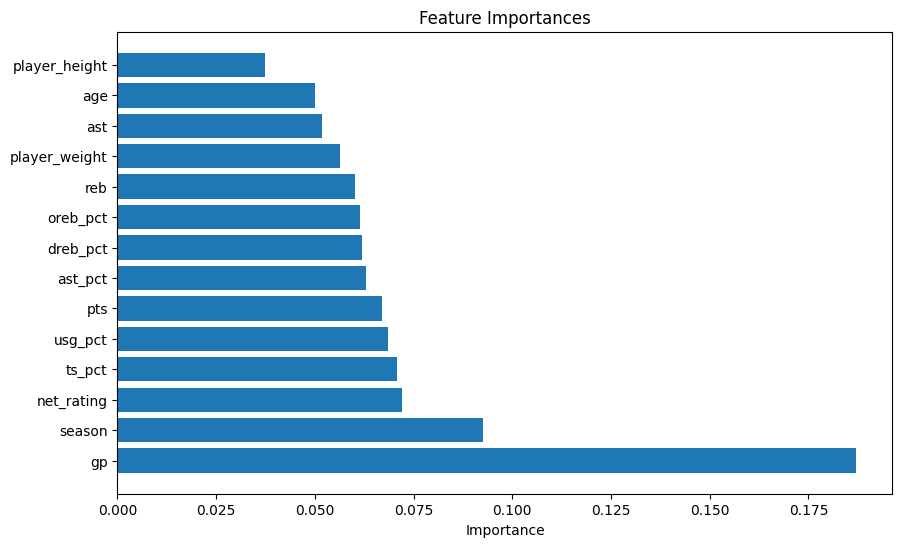

In [378]:
feature_names = injuries_bool.columns[:-1]
importances = rfc_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

Plot injuries season-over-season

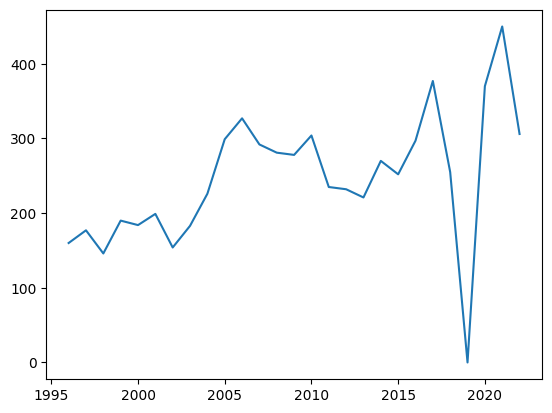

In [417]:
#2019 is removed
x = range(1996, 2023)
y = [0 for i in range(2022-1995)]
for i in range(len(injuries_bool['season'])):
  if(not i==10631):
    y[injuries_bool['season'][i]-1996]+=injuries_bool['injuries'][i]
plt.plot(x, y)
plt.show()

In [418]:
y

[160,
 177,
 146,
 190,
 184,
 199,
 154,
 183,
 226,
 299,
 327,
 292,
 281,
 278,
 304,
 235,
 232,
 221,
 270,
 252,
 297,
 377,
 255,
 0,
 370,
 450,
 306]

In [419]:
injuries_bool[(injuries_bool['season']==2019) & (injuries_bool['injuries']==1)]

,age,player_height,player_weight,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,injuries


In [420]:
player_stats[(player_stats['season']==1998) & (player_stats['player_name'] =='Will Perdue')]

,player_name,team_abbreviation,age,player_height,player_weight,college,country,draft_year,draft_round,draft_number,...,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,injuries
1315,Will Perdue,SAS,33.0,213.36,108.86208,Vanderbilt,USA,1988,1,11,...,3.7,0.5,5.6,0.096,0.245,0.098,0.63,0.064,1998,[ankle]


# **Association Rule Mining**

In [421]:
from mlxtend.frequent_patterns import apriori, association_rules

In [422]:
injuries_bool

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,age,player_height,player_weight,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,injuries
0,33.0,205.74,102.058200,83,7.2,7.9,0.8,-8.0,0.100,0.207,0.119,0.523,0.045,1996,0
1,24.0,195.58,94.800728,83,5.2,2.7,1.9,5.2,0.031,0.129,0.147,0.524,0.163,1996,0
2,25.0,205.74,102.058200,33,6.2,4.3,0.5,-8.3,0.129,0.163,0.168,0.599,0.051,1996,0
3,27.0,210.82,108.862080,47,4.0,2.0,0.4,-6.4,0.079,0.140,0.224,0.435,0.077,1996,0
4,27.0,205.74,109.315672,62,3.8,3.5,0.5,6.7,0.110,0.177,0.126,0.572,0.051,1996,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12310,25.0,210.82,113.398000,63,11.6,6.4,2.9,-7.5,0.076,0.190,0.209,0.599,0.180,2022,1
12311,28.0,195.58,90.718400,77,24.8,4.5,4.2,0.3,0.016,0.108,0.278,0.607,0.187,2022,1
12312,22.0,205.74,108.862080,53,5.2,2.6,0.3,-5.9,0.087,0.099,0.149,0.620,0.040,2022,1
12313,21.0,205.74,83.914520,37,5.7,2.1,0.9,-5.2,0.028,0.105,0.178,0.511,0.086,2022,1


In [ ]:
arm = injuries_bool.copy()
for column in arm.columns:
  for i in range(len(arm)):
    if arm[column][i]>=arm[column].mean():
      arm[column][i] = 1
    else:
      arm[column][i] = 0


In [424]:
arm

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,age,player_height,player_weight,gp,pts,reb,ast,net_rating,oreb_pct,dreb_pct,usg_pct,ts_pct,ast_pct,season,injuries
0,1.0,1.0,1.0,1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0,0
1,0.0,0.0,0.0,1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0,0
2,0.0,1.0,1.0,0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0,0
3,0.0,1.0,1.0,0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0,0
4,0.0,1.0,1.0,1,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12310,1.0,1.0,1.0,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1
12311,1.0,1.0,1.0,1,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1,1
12312,1.0,1.0,1.0,1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1,1
12313,1.0,1.0,1.0,1,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1


In [425]:
arm_sets = apriori(arm, min_support = 0.1, use_colnames=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [426]:
arm_rules = association_rules(arm_sets, metric= 'lift', min_threshold = 1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [427]:
arm_rules

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(player_height),(age),0.981161,0.948924,0.937312,0.955309,1.006729,0.006265,1.142871,0.354785
1,(age),(player_height),0.948924,0.981161,0.937312,0.987763,1.006729,0.006265,1.539513,0.130859
2,(player_weight),(age),0.947219,0.948924,0.910678,0.961423,1.013172,0.011839,1.324001,0.246310
3,(age),(player_weight),0.948924,0.947219,0.910678,0.959695,1.013172,0.011839,1.309556,0.254533
4,(gp),(age),0.796671,0.948924,0.768088,0.964122,1.016016,0.012108,1.423596,0.077526
...,...,...,...,...,...,...,...,...,...,...
215103,(player_weight),"(pts, gp, ts_pct, net_rating, reb, injuries, a...",0.947219,0.101746,0.101340,0.106987,1.051509,0.004964,1.005869,0.928100
215104,(ast),"(pts, gp, ts_pct, net_rating, reb, injuries, p...",0.544702,0.125376,0.101340,0.186047,1.483914,0.033048,1.074539,0.716248
215105,(season),"(pts, gp, ts_pct, net_rating, reb, injuries, p...",0.993341,0.101421,0.101340,0.102019,1.005897,0.000594,1.000666,0.880462
215106,(player_height),"(pts, gp, ts_pct, net_rating, reb, injuries, p...",0.981161,0.101340,0.101340,0.103286,1.019201,0.001909,1.002170,1.000000


In [428]:
arm_result_injuries = arm_rules[arm_rules['consequents']==frozenset({'injuries'})]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [440]:
arm_result_injuries[(arm_result_injuries['confidence']>=0.5) & (arm_result_injuries['lift']>1.07)]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
45051,"(ts_pct, reb, ast, player_weight, age)",(injuries),0.291027,0.541291,0.168819,0.580078,1.071656,0.011288,1.092367,0.094313
79476,"(ts_pct, reb, player_weight, ast, player_heigh...",(injuries),0.290865,0.541291,0.168737,0.580123,1.071739,0.011295,1.092484,0.094393
94831,"(gp, ts_pct, reb, ast, player_weight, age)",(injuries),0.285099,0.541291,0.165489,0.580461,1.072365,0.011167,1.093365,0.094393
97187,"(pts, ts_pct, reb, ast, player_weight, age)",(injuries),0.289160,0.541291,0.167682,0.579893,1.071315,0.011162,1.091887,0.093647
99320,"(ts_pct, reb, ast, season, player_weight, age)",(injuries),0.290540,0.541291,0.168656,0.580492,1.072421,0.011389,1.093445,0.095185
131546,"(player_height, gp, ts_pct, reb, ast, player_w...",(injuries),0.285018,0.541291,0.165489,0.580627,1.072670,0.011211,1.093796,0.094753
136312,"(pts, player_height, ts_pct, reb, ast, player_...",(injuries),0.288997,0.541291,0.167600,0.579938,1.071398,0.011169,1.092003,0.093727
140621,"(player_height, ts_pct, reb, ast, season, play...",(injuries),0.290459,0.541291,0.168575,0.580375,1.072204,0.011352,1.093139,0.094909
150737,"(pts, gp, ts_pct, reb, ast, player_weight, age)",(injuries),0.283475,0.541291,0.164352,0.579777,1.071099,0.010910,1.091583,0.092641
154798,"(gp, ts_pct, reb, ast, season, player_weight, ...",(injuries),0.284612,0.541291,0.165327,0.580884,1.073146,0.011269,1.094469,0.095278


Other papers used game by game data to see what happened in the previous game;
Add other datasets;
Try with non-numeric;
Find some variables that could be correlated, or teams have discussed(Wisdom that relates to certain things);
ethnicity, country, etc;
**Later**: Artificially create data; maybe add minutes played